# Data Preparation

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data Sets

In [2]:
# read the movie data sets into DataFrame
metadata = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/movies_metadata.csv')
credits =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/credits.csv')
keywords =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/keywords.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read the rating data sets into DataFrame
ratings = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/ratings.csv')
links = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/links.csv')

### Merge Data Sets into a Single DataFrame
- TMDb 'id' is used as the key column to combine datasets

In [4]:
# ensure data accuracy of 'id'
metadata[metadata['id'].str.contains('-') == True]

# swap values between 'id' and 'release_date' for misplaced observations
swap_condition = metadata['id'].str.contains('-') == True
ary=np.where(swap_condition,[metadata.release_date,metadata.id],[metadata.id,metadata.release_date])
metadata.id = ary[0]
metadata.release_date = ary[1]

# convert the data type of 'id' from string to int
metadata['id'] = metadata['id'].astype(int)

In [5]:
# merge three datasets with movie features into movie
movie = metadata.merge(credits.merge(keywords, on='id'), on='id')
movie = movie.drop(movie.index[(movie.title.isna()== True)])

#### Preprocessing Raw Data - Ratings
1.Each observation is ratings dataset is a rating record given by a user to a movie. We need to compute certain values, including 
- 'average_rating': By dividing the sum of rating by the vote number for each movie, we'll get our target variable for this project.
- 'votes_per_user': By counting how many votes each user gives, the number helps to identify frequent raters.
- 'votes_per_movie': By counting how many votes each movie receives, the number helps to identify the most-voted movie.

2.The ratings data need to merge with links dataset to get the 'id' column before merging with movie dataset.

In [6]:
# get average_rating
ratings['average_rating'] = ratings.groupby('movieId')['rating'].transform(np.mean)
# get votes_per_user
ratings['votes_per_user'] = ratings.groupby('userId')['movieId'].transform('count')
# votes_per_movie
ratings['votes_per_movie'] = ratings.groupby('movieId')['userId'].transform('count')

In [7]:
ratings.head()

,userId,movieId,rating,timestamp,average_rating,votes_per_user,votes_per_movie
0,1,110,1.0,1425941529,4.016057,27,66512
1,1,147,4.5,1425942435,3.595933,27,4967
2,1,858,5.0,1425941523,4.339811,27,57070
3,1,1221,5.0,1425941546,4.263475,27,36679
4,1,1246,5.0,1425941556,3.912803,27,25752


In [8]:
# merge ratings with links in order to acquire movieId column
ratings_clean = pd.merge(ratings,links,on='movieId')
# ignore the user data for now, keep one column for one movie rating record
ratings_clean = ratings_clean.drop_duplicates('tmdbId')[['tmdbId','votes_per_movie','average_rating']]

In [9]:
# prepare for the merge
ratings_clean  = ratings_clean.loc[pd.notnull(ratings_clean['tmdbId']) != False]

In [10]:
# prepare for the combination
ratings_clean.rename(columns = {'tmdbId':'id'}, inplace = True)
ratings_clean = ratings_clean.astype({'id': 'int64'})

In [11]:
ratings_clean.head()

,id,votes_per_movie,average_rating
0,197,66512,4.016057
66512,10474,4967,3.595933
71479,238,57070,4.339811
128549,240,36679,4.263475
165228,207,25752,3.912803


In [12]:
# merge the movie dateset with rating dataset
df_initial = pd.merge(ratings_clean,movie,on='id')
df_initial.shape

(45879, 29)

#### Computing our target variable: Weighted Rating, using IMDB Formula
- v: number of votes for the movie 
    - which is the value in column 'votes_per_movie'
- m: the minimum votes required to be listed in the chart
- R: average rating of the movie
    - which is the value in column 'average_rating'
- C: the mean rating of overall movies

In [13]:
# m is the minumum votes required to be listed in the chart
m = df_initial['votes_per_movie'].quantile(0.75)
m

67.0

In [14]:
# C is the mean rating across the whole report
C = df_initial['average_rating'].mean()
C

3.0588446332765327

In [15]:
# filter the movies qualified for the chart
df = df_initial[df_initial['votes_per_movie'] >= m]
df.shape

(11479, 29)

In [16]:
# calculate weighted_rating
def weighted_rating(x):
    v = x['votes_per_movie']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
df['weighted_rating'] = df.apply(weighted_rating, axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Data Cleaning

In [18]:
df.head()

,id,votes_per_movie,average_rating,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,weighted_rating
0,197,66512,4.016057,False,NaN,72000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0112573,en,...,Released,Every man dies. Not every man truly lives.,Braveheart,False,7.7,3404.0,"[{'cast_id': 5, 'character': 'William Wallace'...","[{'credit_id': '52fe4225c3a36847f80079c1', 'de...","[{'id': 30, 'name': 'individual'}, {'id': 388,...",4.015094
1,10474,4967,3.595933,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0112461,en,...,Released,The true story of the death of innocence and t...,The Basketball Diaries,False,7.2,472.0,"[{'cast_id': 9, 'character': 'Jim Carroll', 'c...","[{'credit_id': '52fe43779251416c7501167d', 'de...","[{'id': 6075, 'name': 'sport'}, {'id': 6496, '...",3.588785
2,238,57070,4.339811,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,tt0068646,en,...,Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de...","[{'id': 131, 'name': 'italy'}, {'id': 699, 'na...",4.338309
3,240,36679,4.263475,False,"{'id': 230, 'name': 'The Godfather Collection'...",13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0071562,en,...,Released,"I don't feel I have to wipe everybody out, Tom...",The Godfather: Part II,False,8.3,3418.0,"[{'cast_id': 8, 'character': 'Don Michael Corl...","[{'credit_id': '52fe422bc3a36847f80094dd', 'de...","[{'id': 700, 'name': 'italo-american'}, {'id':...",4.261279
4,207,25752,3.912803,False,NaN,16400000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0097165,en,...,Released,He was their inspiration. He made their lives ...,Dead Poets Society,False,8.1,2786.0,"[{'cast_id': 3, 'character': 'John Keating', '...","[{'credit_id': '52fe4227c3a36847f8008045', 'de...","[{'id': 30, 'name': 'individual'}, {'id': 490,...",3.910587


In [19]:
# original columns
df.columns

Index(['id', 'votes_per_movie', 'average_rating', 'adult',
       'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'cast',
       'crew', 'keywords', 'weighted_rating'],
      dtype='object')

In [20]:
df.shape

(11479, 30)

### Remove Duplicates and Irrelevant Data

In [21]:
# 'id' should be unique values, thus it is selected to find duplicate records
duplicated_filter = df.duplicated('id') == True
# count the number of duplicated rows
duplicated_filter.sum()

132

In [22]:
# remove the duplicates with identical values of 'id'
df.drop_duplicates(subset=['id'], inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# drop irrelevant columns that do not fit to the objectives of this project
to_keep_features = ['id','weighted_rating','votes_per_movie', 'average_rating','title', 'budget','revenue', 'release_date', 'runtime', 'genres', 'production_countries','production_companies','original_language','cast','crew','overview', 'keywords']
df = df[to_keep_features]

In [24]:
df.columns

Index(['id', 'weighted_rating', 'votes_per_movie', 'average_rating', 'title',
       'budget', 'revenue', 'release_date', 'runtime', 'genres',
       'production_countries', 'production_companies', 'original_language',
       'cast', 'crew', 'overview', 'keywords'],
      dtype='object')

In [25]:
# get the summary of df
print ('number of rows/observations: {}'.format(df.shape[0]))
print ('number of columns/features: {}'.format(df.shape[1]))

number of rows/observations: 11347
number of columns/features: 17


In [26]:
original = df.describe()
original

,id,weighted_rating,votes_per_movie,average_rating,revenue,runtime
count,11347.000000,11347.000000,11347.000000,11347.000000,1.134700e+04,11347.000000
mean,43715.319820,3.253373,2260.407068,3.281782,4.330111e+07,105.866837
std,71253.235951,0.420185,5734.215568,0.492631,1.226585e+08,30.771655
min,2.000000,1.256012,67.000000,0.880342,0.000000e+00,0.000000
25%,9889.500000,3.010058,156.000000,2.995713,0.000000e+00,92.000000
50%,17409.000000,3.287304,430.000000,3.356099,3.990000e+02,102.000000
75%,41022.500000,3.542944,1590.500000,3.649022,2.824636e+07,115.000000
max,449674.000000,4.428007,91921.000000,4.478780,2.787965e+09,900.000000


### Detect Missing Data

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11347 entries, 0 to 24752
Data columns (total 17 columns):
id                      11347 non-null int64
weighted_rating         11347 non-null float64
votes_per_movie         11347 non-null int64
average_rating          11347 non-null float64
title                   11347 non-null object
budget                  11347 non-null object
revenue                 11347 non-null float64
release_date            11346 non-null object
runtime                 11347 non-null float64
genres                  11347 non-null object
production_countries    11347 non-null object
production_companies    11347 non-null object
original_language       11347 non-null object
cast                    11347 non-null object
crew                    11347 non-null object
overview                11341 non-null object
keywords                11347 non-null object
dtypes: float64(4), int64(2), object(11)
memory usage: 1.6+ MB


#### Detect Unstandardized Missing Values

In [28]:
df[df['budget'] == '0']

,id,weighted_rating,votes_per_movie,average_rating,title,budget,revenue,release_date,runtime,genres,production_countries,production_companies,original_language,cast,crew,overview,keywords
1,10474,3.588785,4967,3.595933,The Basketball Diaries,0,0.0,1995-04-21,102.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'New Line Cinema', 'id': 12}, {'name...",en,"[{'cast_id': 9, 'character': 'Jim Carroll', 'c...","[{'credit_id': '52fe43779251416c7501167d', 'de...",Film adaptation of street tough Jim Carroll's ...,"[{'id': 6075, 'name': 'sport'}, {'id': 6496, '..."
22,64678,3.325825,318,3.382075,The Art of Getting By,0,1406224.0,2011-06-17,83.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Goldcrest Films International', 'id...",en,"[{'cast_id': 2, 'character': 'George Zinavoy',...","[{'credit_id': '593c6b79c3a3680f590129a9', 'de...","George, a lonely and fatalistic teen who's mad...","[{'id': 490, 'name': 'philosophy'}, {'id': 131..."
27,11862,3.079474,15258,3.079565,Father of the Bride Part II,0,76578911.0,1995-02-10,106.0,"[{'id': 35, 'name': 'Comedy'}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Sandollar Productions', 'id': 5842}...",en,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",Just when George Banks has recovered from his ...,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
30,11010,3.960485,13347,3.965011,The Postman,0,0.0,1994-09-22,108.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_3166_1': 'BE', 'name': 'Belgium'}, {'is...",[],it,"[{'cast_id': 11, 'character': 'Pablo Neruda', ...","[{'credit_id': '52fe43e29251416c75021d97', 'de...",Simple Italian postman learns to love poetry w...,"[{'id': 2041, 'name': 'island'}, {'id': 3344, ..."
31,19760,2.844099,2188,2.837523,Two If by Sea,0,0.0,1996-01-12,96.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",en,"[{'cast_id': 1, 'character': 'Roz', 'credit_id...","[{'credit_id': '52fe47ef9251416c750aa5b1', 'de...","Frank O'Brien, a petty thief, and his 7-year-l...","[{'id': 2041, 'name': 'island'}, {'id': 5918, ..."
37,7300,3.304249,3803,3.308572,One Fine Day,0,97529550.0,1996-12-20,108.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...","[{'iso_3166_1': 'US', 'name': 'United States o...",[{'name': 'Twentieth Century Fox Film Corporat...,en,"[{'cast_id': 1, 'character': 'Melanie Parker',...","[{'credit_id': '52fe4478c3a36847f80980eb', 'de...","Melanie Parker, an architect and mother of Sam...","[{'id': 238179, 'name': 'skab under tv'}, {'id..."
56,15592,3.166206,1506,3.170983,Beaches,0,57041866.0,1988-12-21,123.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Touchstone Pictures', 'id': 9195}, ...",en,"[{'cast_id': 2, 'character': ""Cecilia 'CC' Car...","[{'credit_id': '52fe46699251416c750777ed', 'de...",A privileged rich debutante and a cynical stru...,"[{'id': 4959, 'name': 'death of a friend'}, {'..."
58,9409,2.819514,3302,2.814658,Another Stakeout,0,0.0,1993-07-22,105.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Touchstone Pictures', 'id': 9195}]",en,"[{'cast_id': 19, 'character': 'Det. Chris Lecc...","[{'credit_id': '52fe44f4c3a36847f80b3ea5', 'de...",Chris and Bill are called upon for their excel...,"[{'id': 4171, 'name': 'staatsanwältin'}, {'id'..."
60,9415,3.083595,3216,3.084111,Murder at 1600,0,25804707.0,1997-04-18,107.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Regency Enterprises', 'id': 508}, {...",en,"[{'cast_id': 1, 'character': 'Detective Harlan...","[{'credit_id': '52fe44f4c3a36847f80b4109', 'de...",A secretary is found

In [29]:
# examine the value of zero in budget column
df[df['budget'] == '0'].production_companies[:3]

1     [{'name': 'New Line Cinema', 'id': 12}, {'name...
22    [{'name': 'Goldcrest Films International', 'id...
27    [{'name': 'Sandollar Productions', 'id': 5842}...
Name: production_companies, dtype: object

- some of movies with zero budget are produced by big companies, such as Warner Bros. and Disney
- it is probably that missing value is represented with value of zero
- the same situation is observed in 'revenue' column 

In [30]:
# summary of missing values of budget
budget_missing = df.budget == '0'
print ('number of missing values in budget column: ', budget_missing.sum())
print ('percentage of missing values in budget column: ', budget_missing.sum()/df.shape[0])

number of missing values in budget column:  5747
percentage of missing values in budget column:  0.5064774830351635


In [31]:
# summary of missing values of revenue
revenue_missing = df.revenue == 0
print ('number of missing values in revenue column: ', revenue_missing.sum())
print ('percentage of missing values in revenue column: ', revenue_missing.sum()/df.shape[0])

number of missing values in revenue column:  5622
percentage of missing values in revenue column:  0.4954613554243412


In [32]:
# drop the row where revenue and budget both equal to 0
df['budget'] = df['budget'].astype(int)

In [33]:
df['revenue'].dtype

dtype('float64')

In [34]:
df = df[(df['budget'] != 0) & (df['revenue']!=0)]
df.shape

(4532, 17)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4532 entries, 0 to 23760
Data columns (total 17 columns):
id                      4532 non-null int64
weighted_rating         4532 non-null float64
votes_per_movie         4532 non-null int64
average_rating          4532 non-null float64
title                   4532 non-null object
budget                  4532 non-null int64
revenue                 4532 non-null float64
release_date            4532 non-null object
runtime                 4532 non-null float64
genres                  4532 non-null object
production_countries    4532 non-null object
production_companies    4532 non-null object
original_language       4532 non-null object
cast                    4532 non-null object
crew                    4532 non-null object
overview                4531 non-null object
keywords                4532 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 637.3+ KB


### Create New Variables

In [36]:
# convert 'release_date' to datetime object 
df['release_date'] = pd.to_datetime(df['release_date'])

# extract the 'month' and 'year' from 'release_date'
# replace missing values with zero
df['month'] = df['release_date'].dt.month.astype(np.int64)
df['year'] = df['release_date'].dt.year.astype(np.int64)
df.drop(labels = 'release_date', axis = 1, inplace = True)

### Extract Nested Values

In [37]:
from ast import literal_eval

In [38]:
# extract director from the crew colum
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
df['director'] = df['crew'].apply(literal_eval).apply(get_director)
df.drop(columns=['crew'], inplace = True)

In [39]:
# extract the main production country
df.production_countries = df.production_countries.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_countries = df.production_countries.apply(lambda x: "" if len(x) == 0 else x[0])

In [40]:
# convert keywords and only get the top 3 keywords
df.keywords = df.keywords.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.keywords = df.keywords.apply(lambda x: x[:3] if len(x) >=3 else x)

In [41]:
# convert genres and only get the top 3 genres
df.genres = df.genres.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.genres = df.genres.apply(lambda x: x[:3] if len(x) >=3 else x)

In [42]:
# extract the main production country
df.production_companies = df.production_companies.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_companies = df.production_companies.apply(lambda x: "" if len(x) == 0 else x[0])

In [43]:
# convert cast and only get the top 3 actors/actess
df.cast = df.cast.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.cast = df.cast.apply(lambda x: x[:3] if len(x) >=3 else x)

# EDA

# Target Variable

### What's the frequency distribution of weighted rating per movie?

In [44]:
import statsmodels.api as sm
import scipy 

count    4532.000000
mean        3.239290
std         0.451903
min         1.256012
25%         2.944909
50%         3.261477
75%         3.564859
max         4.428007
Name: weighted_rating, dtype: float64

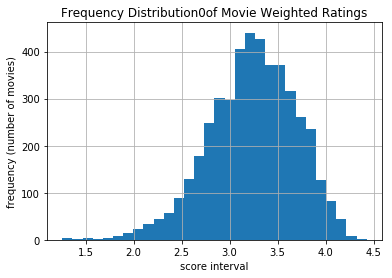

In [45]:
# plot a histogram to show the frequency distribution of weighted rating per movie
df['weighted_rating'].hist(bins=30) 
plt.title('Frequency Distribution0of Movie Weighted Ratings')
plt.xlabel('score interval')
plt.ylabel('frequency (number of movies)')
df.weighted_rating.describe()

Findings:
- The average rating per movie is normally distributed, with majority of movies score in the middle (between 3-3.5) and less receiving high score above 4 and low below 2.

In [46]:
# list out the Top 10 highly-scored movies
df[['title','weighted_rating','average_rating','votes_per_movie']].sort_values(by = 'weighted_rating', ascending=False)[:10]

,title,weighted_rating,average_rating,votes_per_movie
140,The Shawshank Redemption,4.428007,4.429015,91082
2,The Godfather,4.338309,4.339811,57070
537,The Usual Suspects,4.298787,4.300189,59271
51,Schindler's List,4.265336,4.266531,67662
3,The Godfather: Part II,4.261279,4.263475,36679
219,Seven Samurai,4.249374,4.255074,13994
8,Fight Club,4.229409,4.230716,60024
587,Rear Window,4.228878,4.232552,21335
119,One Flew Over the Cuckoo's Nest,4.227183,4.229135,40103
1709,12 Angry Men,4.226578,4.231209,16896


### What's the frequency distribution of rating scores?

count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

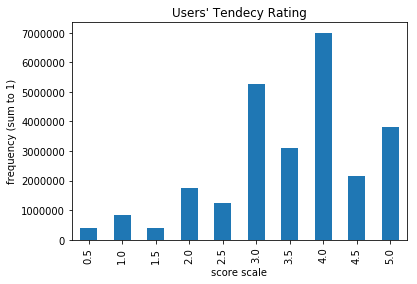

In [47]:
# calculate the distribution of each rating interval, ranging from 0.5 to 5
ratings.groupby('rating').size().plot(kind = 'bar')
plt.title("Users' Tendecy Rating")
plt.xlabel('score scale')
plt.ylabel('frequency (sum to 1)')

ratings.rating.describe()

Findings:
- The high number of 5 ratings might be an indication of users to give a high rating.

### Numeric Variable

#### How many ratings a movie receive?

In [48]:
print (df.votes_per_movie.max())
print (df.votes_per_movie.min())

91921
67


count     4532.000000
mean      4522.890997
std       8346.593498
min         67.000000
25%        421.000000
50%       1334.500000
75%       4836.000000
max      91921.000000
Name: votes_per_movie, dtype: float64

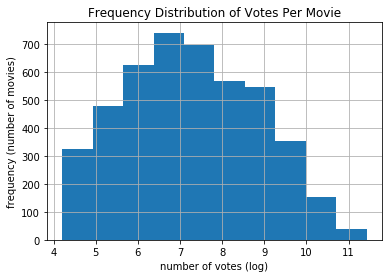

In [49]:
np.log(df.votes_per_movie).hist()
plt.title('Frequency Distribution of Votes Per Movie')
plt.xlabel('number of votes (log)')
plt.ylabel('frequency (number of movies)')

df.votes_per_movie.describe()
# look at 25% to 75% when doing variance comparison
# when interpret and discuss the data, look at the main values of the data
# 10% and 90%
# more reasonble 
# the distribution is not normal (comparing mean and median and look at std)

count     4532.000000
mean      4522.890997
std       8346.593498
min         67.000000
25%        421.000000
50%       1334.500000
75%       4836.000000
max      91921.000000
Name: votes_per_movie, dtype: float64

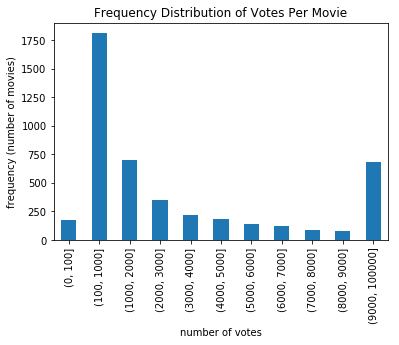

In [50]:
bins = [0, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,9000,100000]
df.groupby(pd.cut(df['votes_per_movie'], bins))['votes_per_movie'].count().plot(kind = 'bar')
plt.title('Frequency Distribution of Votes Per Movie')
plt.xlabel('number of votes')
plt.ylabel('frequency (number of movies)')

df.votes_per_movie.describe()

Findings:
- The number of votes vary dramatically. Majority of movies receive less than 10 votes while the most rated movie, Forrest Gump, has 91921 votes.

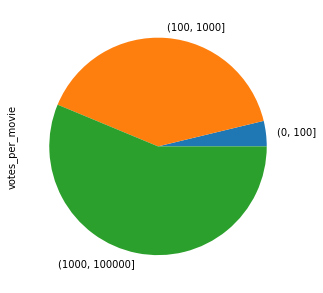

In [51]:
bins2 = [0, 100, 1000, 100000]
df.groupby(pd.cut(df['votes_per_movie'], bins2))['votes_per_movie'].count().plot.pie(y='mass', figsize=(5, 5))

- for numeric data, NaN values are now represented with zero
- when plotting data distribution, we would like to know how effective data points are located, so we'll remove data points with zero-value

### What's the data distribution of budget?
- Does the budget of each movie vary dramatically? 
- What's the budget for majority of movies?

count    4.532000e+03
mean     3.519690e+07
std      4.205381e+07
min      1.000000e+00
25%      7.500000e+06
50%      2.000000e+07
75%      4.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

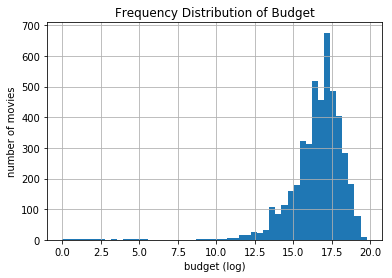

In [52]:
# log the budget value
ax = np.log(df.budget).hist(bins=50) 
plt.title('Frequency Distribution of Budget')
plt.xlabel('budget (log)')
plt.ylabel('number of movies')

df.budget.describe()

#### Movies with higher budget can have better result? Any low budget movies turn out to be blockbusters?

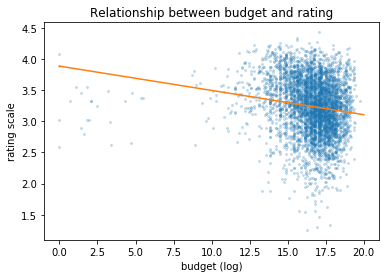

correlation:-0.155, p-value0.000


In [53]:
# plot the budget versus weighted rating
ax = plt.plot(np.log(df.budget),df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between budget and rating')
plt.xlabel('budget (log)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(np.log(df.budget), df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 20])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(np.log(df.budget), df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

### What's the data distribution of revenue?

count    4.532000e+03
mean     1.042532e+08
std      1.767411e+08
min      1.000000e+00
25%      1.158752e+07
50%      4.015428e+07
75%      1.181082e+08
max      2.787965e+09
Name: revenue, dtype: float64

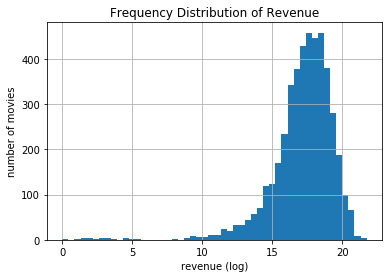

In [54]:
# log the revenue value
ax = np.log(df.revenue).hist(bins=50) 
plt.title('Frequency Distribution of Revenue')
plt.xlabel('revenue (log)')
plt.ylabel('number of movies')

df.revenue.describe()

count    4.532000e+03
mean     1.042532e+08
std      1.767411e+08
min      1.000000e+00
25%      1.158752e+07
50%      4.015428e+07
75%      1.181082e+08
max      2.787965e+09
Name: revenue, dtype: float64

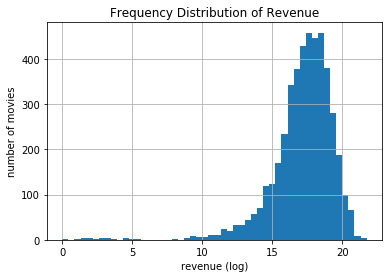

In [55]:
# log the revenue value
ax = np.log(df.revenue).hist(bins=50) 
plt.title('Frequency Distribution of Revenue')
plt.xlabel('revenue (log)')
plt.ylabel('number of movies')

df.revenue.describe()

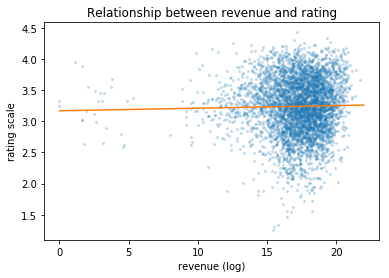

correlation:0.020, p-value0.176


In [56]:
# plot the revenue versus weighted rating
ax = plt.plot(np.log(df.revenue),df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between revenue and rating')
plt.xlabel('revenue (log)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(np.log(df.revenue), df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 22])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr, p = scipy.stats.pearsonr(np.log(df.revenue), df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

#### runtime

count    4532.000000
mean      109.906664
std        20.918743
min        42.000000
25%        96.000000
50%       106.000000
75%       120.000000
max       338.000000
Name: runtime, dtype: float64

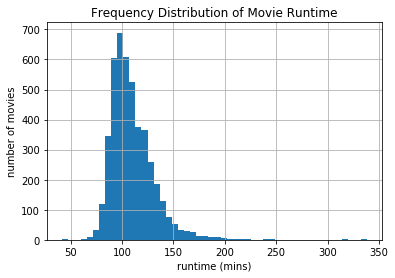

In [57]:
# filter the data with zero-runtime
runtime_to_plot = df[df.runtime != 0]['runtime']

# log the budget value
ax = runtime_to_plot.hist(bins=50) 
ax.set_title('Frequency Distribution of Movie Runtime')
ax.set_xlabel('runtime (mins)')
ax.set_ylabel('number of movies')

runtime_to_plot.describe()

## zoom in 

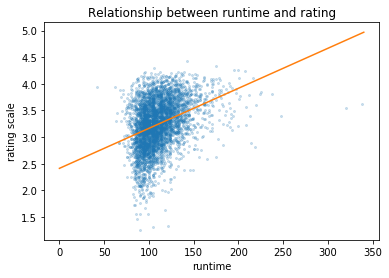

correlation:0.348, p-value0.000


In [58]:
# plot the revenue versus weighted rating
ax = plt.plot(df.runtime ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between runtime and rating')
plt.xlabel('runtime')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(df.runtime, df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 340])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(df.runtime, df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))
# 95% confidence in the relationship between features

#### Does release timing affect the ratings?

In [59]:
# filter the data with zero
month_to_plot = df[df['month'] != 0]['month']

count    4532.000000
mean        6.989409
std         3.377633
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: month, dtype: float64

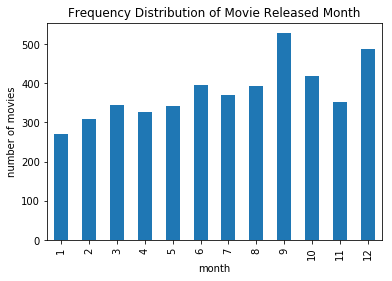

In [60]:
ax = df[df['month'] != 0]['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency Distribution of Movie Released Month')
plt.xlabel('month')
plt.ylabel('number of movies')
df.month.describe()

Text(0, 0.5, 'ratings')

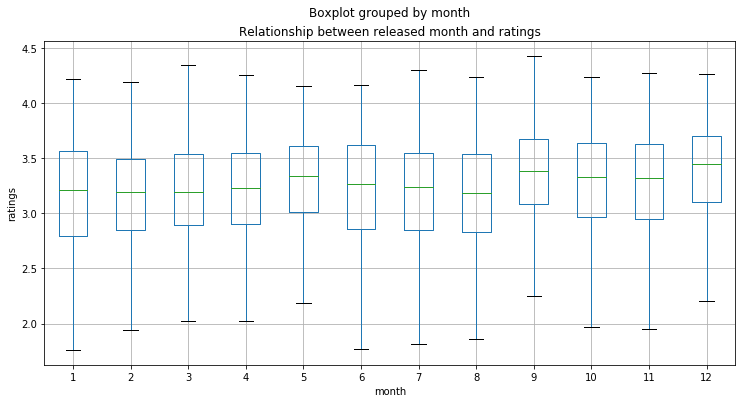

In [61]:
df[df['month'] != 0].boxplot(by='month', column = 'average_rating', figsize=(12,6),
                    widths=0.5, showfliers=False)
plt.title('Relationship between released month and ratings')
plt.xlabel('month')
plt.ylabel('ratings')

# t-test or chi-square
# t-test assumption: when the target variable is continuous and normally distributed


# chi-square dataset represent by binary features, 1 or 0 only 2 categorical

# go through the assumtpion

# use ANOVA test/regression for month and ratings for multiple categories

# execute 1-hot encoding for all categorical features separately
# take 1-hot encoding as an input for the ANOVA hypothesis testing (simple regression)

Findings:
- There's no significant different in median point between movies released in different months.

### Using hypothesis Testing to examine whether released timing affect the movie scores 
1. Making hypothesis
    - H0: The scores are the same among movies released in different months.
    - H1: The scores are different among movies released in different months.
2. Deciding significance level 
    - The significance level (α) for this project is 0.05, which means if the p-value < 0.05, then the null hypothesis will be rejected.

In [83]:
df.columns

Index(['id', 'weighted_rating', 'votes_per_movie', 'average_rating', 'title',
       'budget', 'revenue', 'runtime', 'genres', 'production_countries',
       'production_companies', 'original_language', 'cast', 'overview',
       'keywords', 'month', 'year', 'director'],
      dtype='object')

In [84]:
# import modules
from scipy import stats

# create arrays
Jan = df[df.month == 1].weighted_rating
Feb = df[df.month == 2].weighted_rating
Mar = df[df.month == 3].weighted_rating
Apr = df[df.month == 4].weighted_rating
May = df[df.month == 5].weighted_rating
Jun = df[df.month == 6].weighted_rating
Jul = df[df.month == 7].weighted_rating
Aug = df[df.month == 8].weighted_rating
Sep = df[df.month == 9].weighted_rating
Oct = df[df.month == 10].weighted_rating
Nov = df[df.month == 11].weighted_rating
Dec = df[df.month == 12].weighted_rating

# perform one-way ANOVA
stat,p = stats.f_oneway(Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec)
print ('statistics=%.3f , p=%.3f' %(stat,p))

statistics=10.526 , p=0.000


In [85]:
# interpret
alpha = 0.05
if p > alpha:
    print ('same movie scores among released months (fail to reject H0)')
else:
    print ('different  movie scores among released months (reject H0)')

different  movie scores among released months (reject H0)


### Do new movies generally receive higher or lower scores

count    4532.000000
mean     1999.172109
std        15.115941
min      1915.000000
25%      1993.000000
50%      2003.000000
75%      2010.000000
max      2017.000000
Name: year, dtype: float64

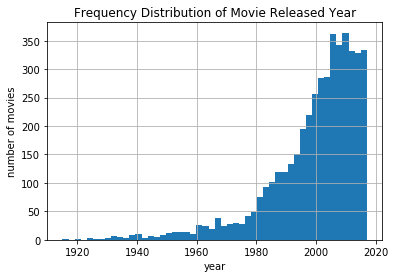

In [62]:
# filter the data with zero
df[(df['year'] != 0) & (df['year'] < 2020)].hist(column='year', bins = 50)
plt.title('Frequency Distribution of Movie Released Year')
plt.xlabel('year')
plt.ylabel('number of movies')
df.year.describe()

Text(0, 0.5, 'rating scale')

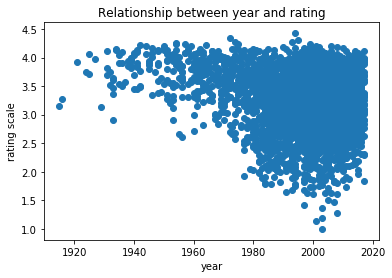

In [63]:
ax = plt.scatter((df[(df['year'] != 0) & (df['year'] < 2020)]['year']), df[(df['year'] != 0) & (df['year'] < 2020)]['average_rating'])
plt.title('Relationship between year and rating')
plt.xlabel('year')
plt.ylabel('rating scale')

### Using hypothesis Testing to examine whether released timing affect the movie scores
- for year, can consider to draw some samples from year. For example, to look at the rating of last five years and the first five years to see if they are comparable

In [94]:
# compare the scores between movies released early and lately
mean_of_early_years = df.nsmallest(10, 'year', keep='all').weighted_rating.mean()
mean_of_late_years = df.nlargest(10, 'year', keep='all').weighted_rating.mean()
print ('the average movie ratings in the earliest 10 years: %3f' %(mean_of_early_years))
print ('the average movie ratings in the latest 10 years: %3f' %(mean_of_late_years))

the average movie ratings in the earliest 10 years: 3.647128
the average movie ratings in the latest 10 years: 3.269654


In [95]:
# create dummy variables
df_dummies = pd.get_dummies(pd.Series(df['year']).apply(pd.Series).stack()).sum(level=0)

In [98]:
print (df_dummies.shape)
print (df.shape)
# why first row is missing

(4532, 93)
(4532, 18)


In [ ]:
# one-way ANOVA test


#### production countries data distribution

In [64]:
# ignore missing observations and take only the 10 countries with the most productions
countries = df[df['production_countries'].map(len) > 0]['production_countries'].value_counts()[:10]

Text(0.5, 1.0, 'USA as the movie-making capital ')

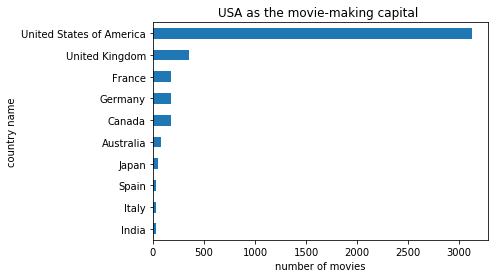

In [65]:
countries.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('country name')
plt.title('USA as the movie-making capital ')

In [66]:
countries.head(10)

United States of America    3123
United Kingdom               355
France                       178
Germany                      174
Canada                       172
Australia                     83
Japan                         54
Spain                         34
India                         33
Italy                         33
Name: production_countries, dtype: int64

#### Relationship between top dominant countires and ratings

In [67]:
condition = (df['production_countries'] == 'United States of America') | (df['production_countries']== 'United Kingdom') | (df['production_countries']== 'France') | (df['production_countries']== 'Canada')| (df['production_countries']== 'Japan')| (df['production_countries']== 'Italy') | (df['production_countries']== 'Germany') | (df['production_countries']== 'Russis')| (df['production_countries']== 'India')| (df['production_countries']== 'Spain')
countries_to_plot = df[condition]

Text(0, 0.5, 'ratings')

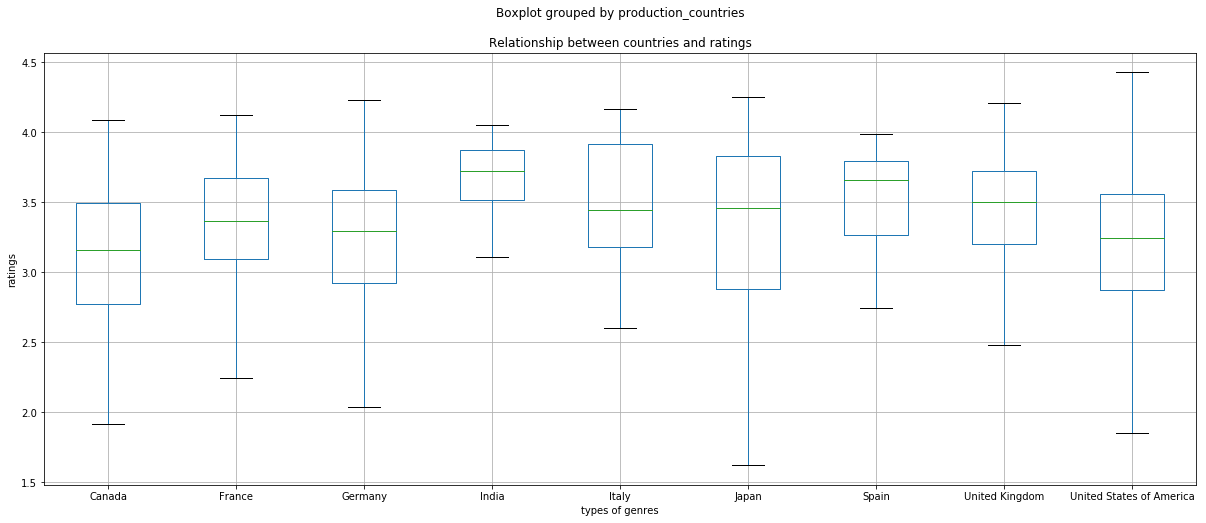

In [68]:
countries_to_plot.boxplot(by='production_countries', column = 'average_rating', figsize=(20,8),
                    widths=0.5, showfliers=False)
plt.title('Relationship between countries and ratings')
plt.xlabel('types of genres')
plt.ylabel('ratings')

In [69]:
# separate the list of genre types from genres column
countries_df = pd.concat([df['production_countries'].apply(pd.Series),df['id']],axis=1)
# keep all genre types within the same column
countries_df = pd.melt(countries_df, id_vars='id',value_name='production_countries').drop(columns='variable').sort_values(by='id')
countries_merge = pd.merge(countries_df,df[['average_rating','id']], on = 'id').sort_values(by=['id'])

In [70]:
countries_merge = countries_merge[pd.notnull(countries_merge['production_countries'])]

Text(0, 0.5, 'ratings')

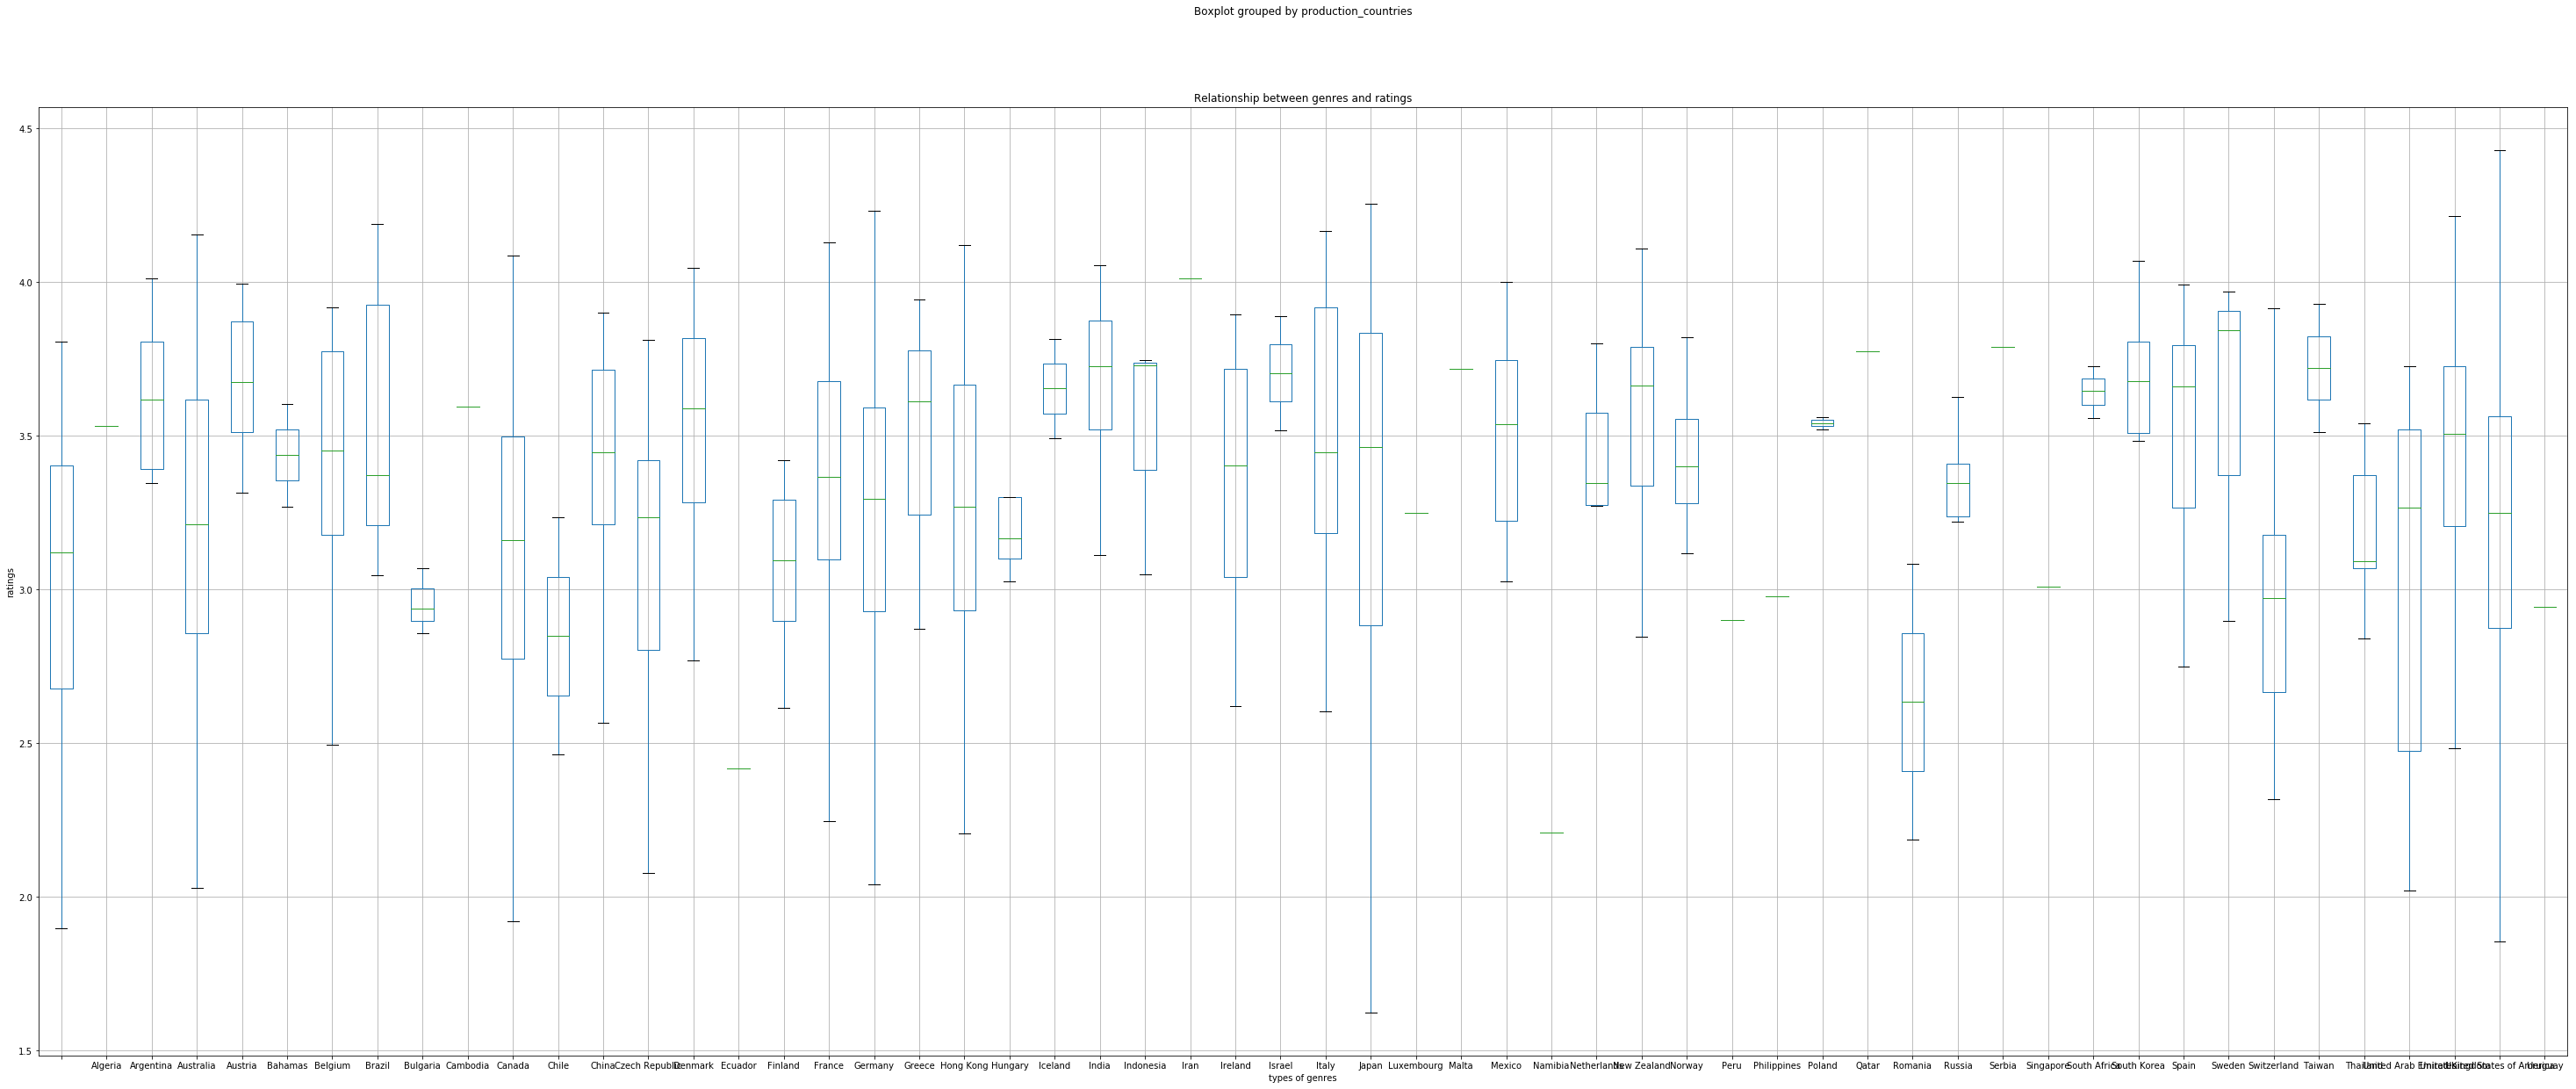

In [71]:
countries_merge.boxplot(by='production_countries', column = 'average_rating', figsize=(50,20),
                    widths=0.5, showfliers=False)
plt.title('Relationship between genres and ratings')
plt.xlabel('types of genres')
plt.ylabel('ratings')

#### production companies data distribution

In [72]:
# ignore missing observations and take only the 10 countries with the most productions
companies = df[df['production_companies'].map(len) > 0]['production_companies'].value_counts()[:20]

Text(0.5, 1.0, 'Most dominant movie companies ')

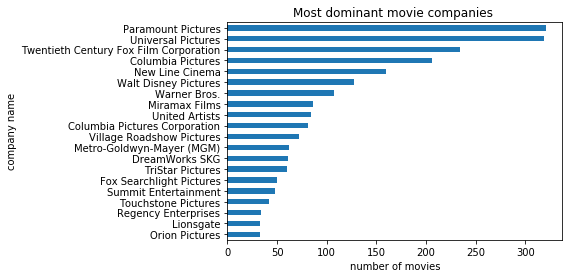

In [73]:
companies.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('company name')
plt.title('Most dominant movie companies ')

Text(0.5, 1.0, 'Most spoken language')

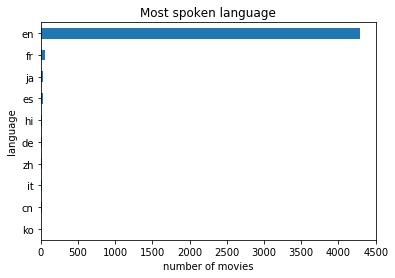

In [74]:
language = df['original_language'].dropna().value_counts()[:10]
language.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('language')
plt.title('Most spoken language')

### Create Other Data Frames with Reshaping Methods
- extract data stored in a list
- in order to facilitate the visualization process
- later on, we would like to have a data frame that calculates the average rating a genre receives

In [75]:
# separate the list of genre types from genres column
genres_df = pd.concat([df['genres'].apply(pd.Series),df['id']],axis=1)

In [76]:
# keep all genre types within the same column
genres_df = pd.melt(genres_df, id_vars='id',value_name='genre').drop(columns='variable').sort_values(by='id')

In [77]:
genres_merge = pd.merge(genres_df,df[['average_rating','id']], on = 'id').sort_values(by=['id'])
genres_merge = genres_merge[pd.notnull(genres_merge['genre'])]

In [78]:
genre_count = pd.DataFrame(genres_merge.groupby('genre').count())
genre_count.reset_index(inplace = True)
genre_count.drop(columns = 'average_rating',inplace = True)
genre_count.columns = ['genre','count']
genre_count = genre_count.sort_values(by='count',ascending=True)

### What types of movies have more productions?

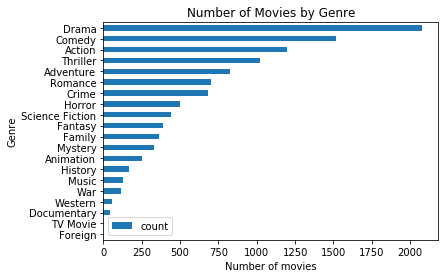

In [79]:
# Plot total number of movies vs genre
genre_count.plot.barh(x = 'genre', y = 'count')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre')

plt.show()

### What's the relationship between genres and ratings

Text(0, 0.5, 'average_ratings')

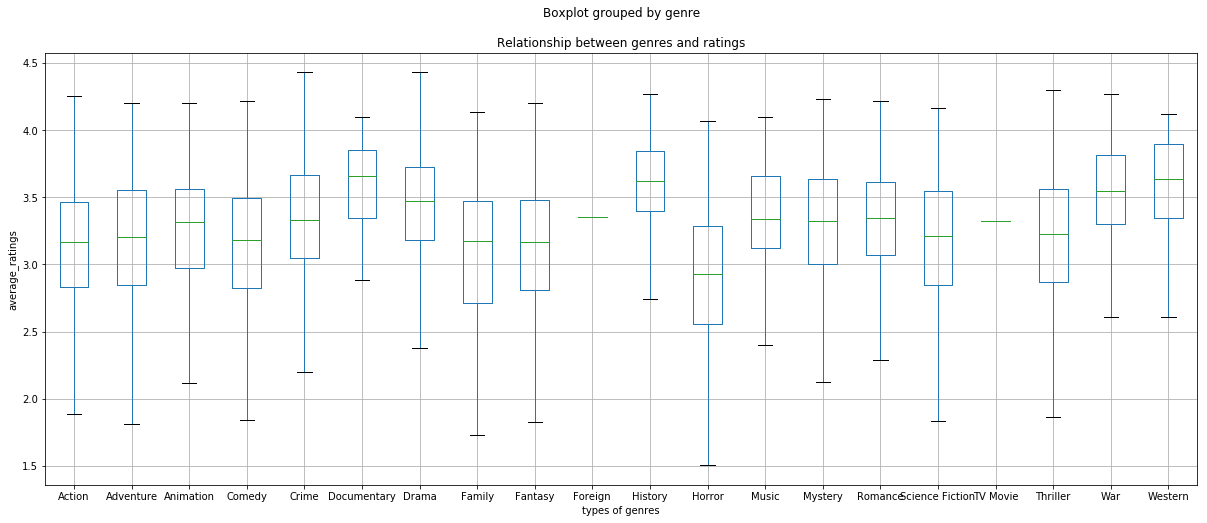

In [80]:
genres_merge.boxplot(by='genre', column = 'average_rating', figsize=(20,8),
                    widths=0.5, showfliers=False)
plt.title('Relationship between genres and ratings')
plt.xlabel('types of genres')
plt.ylabel('average_ratings')

## check if rating is smaller than one